# Manipulating alert data

In [1]:
import requests
import io, gzip, glob, os

import pandas as pd
import numpy as np

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u

import healpy as hp

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

APIURL = 'https://fink-portal.org'

## Loading data

Alert data for the notebooks are in parquet format. You can easily load them using Pandas:

In [2]:
pdf_kn_lc = pd.read_parquet('data/0104_3009_kn_filter1_class.parquet')

nalerts_kn_lc = len(pdf_kn_lc)
nunique_alerts_kn_lc = len(np.unique(pdf_kn_lc['objectId']))

print(
    '{} alerts loaded ({} unique objects)'.format(
        nalerts_kn_lc, 
        nunique_alerts_kn_lc
    )
)

107 alerts loaded (70 unique objects)


How to inspect the data?

In [3]:
pdf_kn_lc.head(1)

,schemavsn,publisher,objectId,candid,candidate,prv_candidates,cutoutScience,cutoutTemplate,cutoutDifference,timestamp,...,day,cjdc,cfidc,cmagpsfc,csigmapsfc,cmagnrc,csigmagnrc,cmagzpscic,cisdiffposc,TNS
0,3.3,Fink,ZTF21abvrrir,1701264402515015016,"{'aimage': 0.7039999961853027, 'aimagerat': 0....","[{'aimage': None, 'aimagerat': None, 'bimage':...",{'fileName': 'candid1701264402515015016_pid170...,{'fileName': 'candid1701264402515015016_ref.fi...,{'fileName': 'candid1701264402515015016_pid170...,2021-08-29 06:20:44.998075,...,29,"[2459426.8683912, 2459428.8301273, 2459428.872...","[1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[26.31089973449707, 26.323999404907227, 26.343...","[None, None, None, None, None, None, None, Non...",


Top level fields can be accessed as usual, e.g. the object ID:

In [4]:
pdf_kn_lc['objectId']

0     ZTF21abvrrir
1     ZTF21absmlzd
2     ZTF21abbkglo
3     ZTF21abdveqn
4     ZTF21abbkglo
          ...     
6     ZTF21acbqmnb
7     ZTF21accmlne
8     ZTF21accmmxm
9     ZTF21acahxze
10    ZTF21accmlne
Name: objectId, Length: 107, dtype: object

Nested fields are dictionary -- so just use:

In [5]:
# extract Right ascension
pdf_kn_lc['candidate'].apply(lambda x: x['ra'])

0     330.051893
1     289.192781
2     235.089039
3     302.908051
4     235.089041
         ...    
6     311.304664
7     308.348480
8     304.323335
9     337.522552
10    308.348450
Name: candidate, Length: 107, dtype: float64

You can easily get the keys for nested fields using:

In [6]:
pdf_kn_lc['candidate'].apply(lambda x: x.keys()).values[0]

dict_keys(['aimage', 'aimagerat', 'bimage', 'bimagerat', 'candid', 'chinr', 'chipsf', 'classtar', 'clrcoeff', 'clrcounc', 'clrmed', 'clrrms', 'dec', 'decnr', 'diffmaglim', 'distnr', 'distpsnr1', 'distpsnr2', 'distpsnr3', 'drb', 'drbversion', 'dsdiff', 'dsnrms', 'elong', 'exptime', 'fid', 'field', 'fwhm', 'isdiffpos', 'jd', 'jdendhist', 'jdendref', 'jdstarthist', 'jdstartref', 'magap', 'magapbig', 'magdiff', 'magfromlim', 'maggaia', 'maggaiabright', 'magnr', 'magpsf', 'magzpsci', 'magzpscirms', 'magzpsciunc', 'mindtoedge', 'nbad', 'ncovhist', 'ndethist', 'neargaia', 'neargaiabright', 'nframesref', 'nid', 'nmatches', 'nmtchps', 'nneg', 'objectidps1', 'objectidps2', 'objectidps3', 'pdiffimfilename', 'pid', 'programid', 'programpi', 'ra', 'ranr', 'rb', 'rbversion', 'rcid', 'rfid', 'scorr', 'seeratio', 'sgmag1', 'sgmag2', 'sgmag3', 'sgscore1', 'sgscore2', 'sgscore3', 'sharpnr', 'sigmagap', 'sigmagapbig', 'sigmagnr', 'sigmapsf', 'simag1', 'simag2', 'simag3', 'sky', 'srmag1', 'srmag2', 'srmag

## Localization of sources

let's see where the candidates are on the sky (glon/glat):

0.0 180.0 -180.0 180.0


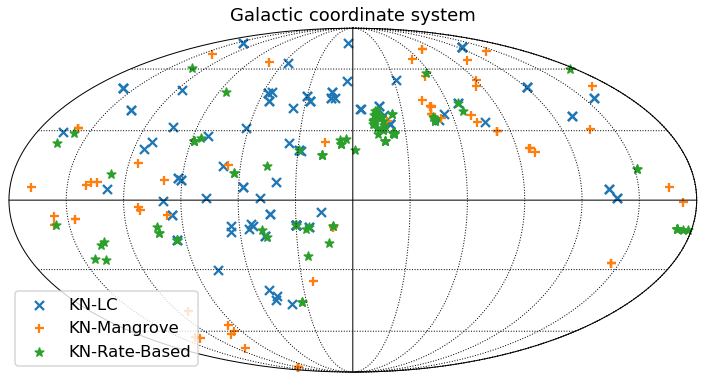

In [7]:
def add_proj(pdf, name, marker):
    coords = SkyCoord(
        pdf['candidate'].apply(lambda x: x['ra']), 
        pdf['candidate'].apply(lambda x: x['dec']), 
        unit='deg'
    )

    hp.projscatter(
        coords.galactic.l, 
        coords.galactic.b,
        lonlat=True,
        marker=marker,
        label=name
    )

pdf1 = pd.read_parquet('data/0104_3009_kn_filter1_class.parquet')
pdf2 = pd.read_parquet('data/0104_3009_kn_filter2_class.parquet')
pdf3 = pd.read_parquet('data/0104_3009_kn_filter3_class.parquet')

fig = plt.figure(0, figsize=(10,10))

hp.mollview(np.array([np.inf] * 12*1024**2), fig=0, title='Galactic coordinate system', cbar=None)

for pdf, name, marker in zip([pdf1, pdf2, pdf3], ['KN-LC', 'KN-Mangrove', 'KN-Rate-Based'], ['x', '+', '*']):
    add_proj(pdf, name, marker)

hp.graticule()
plt.legend()
plt.show()

## Visualising data

You can also benefit from the Fink Portal for visual inspection:

In [8]:
pdf_kn_lc['objectId'].apply(lambda x: '{}/{}'.format(APIURL, x))

0     https://fink-portal.org/ZTF21abvrrir
1     https://fink-portal.org/ZTF21absmlzd
2     https://fink-portal.org/ZTF21abbkglo
3     https://fink-portal.org/ZTF21abdveqn
4     https://fink-portal.org/ZTF21abbkglo
                      ...                 
6     https://fink-portal.org/ZTF21acbqmnb
7     https://fink-portal.org/ZTF21accmlne
8     https://fink-portal.org/ZTF21accmmxm
9     https://fink-portal.org/ZTF21acahxze
10    https://fink-portal.org/ZTF21accmlne
Name: objectId, Length: 107, dtype: object

## Accessing object data

We present here `alert` data, that is the data sent from one trigger at a time. But an object on the sky can emit several alerts, and if you want the aggregated data for an object (that is the data from all the alerts), you can use the Fink API:

In [9]:
oid = pdf_kn_lc['objectId'].values[0]

r = requests.post(
  '{}/api/v1/objects'.format(APIURL),
  json={
    'objectId': oid,
    'withupperlim': 'True'
  }
)

pdf = pd.read_json(r.content)

and plot the data

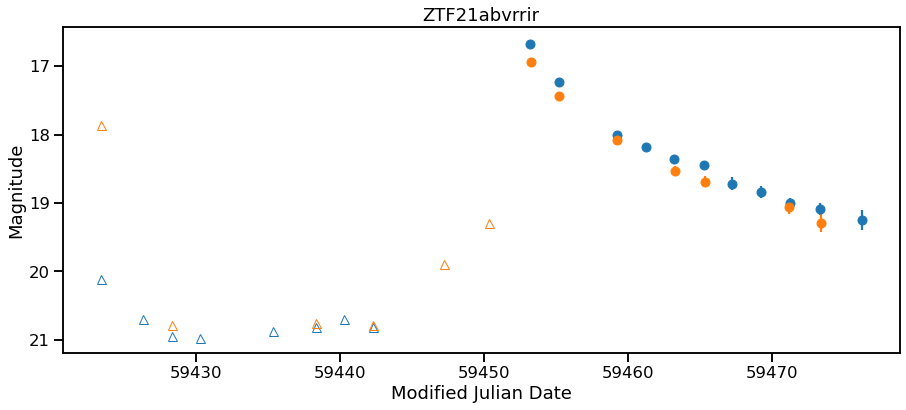

https://fink-portal.org/ZTF21abvrrir


In [10]:
fig = plt.figure(figsize=(15, 6))

colordic = {1: 'C0', 2: 'C1'}

for filt in np.unique(pdf['i:fid']):
    maskFilt = pdf['i:fid'] == filt

    # The column `d:tag` is used to check data type
    maskValid = pdf['d:tag'] == 'valid'
    plt.errorbar(
        pdf[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf[maskValid & maskFilt]['i:magpsf'],
        pdf[maskValid & maskFilt]['i:sigmapsf'],
        ls = '', marker='o', color=colordic[filt]
    )

    maskUpper = pdf['d:tag'] == 'upperlim'
    plt.plot(
        pdf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf[maskUpper & maskFilt]['i:diffmaglim'],
        ls='', marker='^', color=colordic[filt], markerfacecolor='none'
    )

    maskBadquality = pdf['d:tag'] == 'badquality'
    plt.errorbar(
        pdf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf[maskBadquality & maskFilt]['i:magpsf'],
        pdf[maskBadquality & maskFilt]['i:sigmapsf'],
        ls='', marker='v', color=colordic[filt]
    )

plt.gca().invert_yaxis()
plt.xlabel('Modified Julian Date')
plt.ylabel('Magnitude')
plt.title('{}'.format(oid))
plt.show()
print('{}/{}'.format(APIURL, oid))

More information on the Fink API at [http://134.158.75.151:24000/api](http://134.158.75.151:24000/api)

##  Further links

- ZTF alert schema can be found at: https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html
- Fink alert schema (which includes the ZTF one plus additional fields) can be found at: https://fink-portal.org/api/v1/columns

In [11]:
from astropy.time import Time

In [12]:
# kn-lc
pdf1['weekday'] = pdf1['timestamp'].apply(lambda x: Time(x).datetime.isoweekday())

# kn-mangrove
pdf2['weekday'] = pdf2['timestamp'].apply(lambda x: Time(x).datetime.isoweekday())

In [13]:
# all KN-LC
pdf1.groupby('weekday').count()['day']

weekday
1    17
2    20
3    10
4    17
5     3
6    23
7    17
Name: day, dtype: int64

In [14]:
# KN-LC after the fix
pdf1[pdf1['fink_science_version'] > '0.4.4'].groupby('weekday').count()['day']

weekday
1     3
2    11
3     1
4     7
5     2
6     1
7    11
Name: day, dtype: int64

In [15]:
# KN-Mangrove
pdf2[pdf2['fink_science_version'] > '0.4.4'].groupby('weekday').count()['day']

weekday
1    4
2    4
3    1
4    9
5    9
6    5
7    5
Name: day, dtype: int64